In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

<h1>pymoo Tutorial</h1>
pymoo ist eine Python-Bibliothek für multikriterielle Optimierung mittels populationsbasierter Metaheuristiken. Hierzu gehören insb. genetische Algorithmen, die weiter unten im Notebook kurz erläutert werden. Die Bibliothek enthält viele vordefinierte moderne Implementierungen, die auf einfache Weise ausgewählt werden können. 
Außerdem ist es einfach, eigene Anpassungen vorzunehmen, wie zum Beispiel eine selbstdefinierte Mutationstechnik.


Weitere Informationen und Installationsanweisungen:
- https://pymoo.org/ (offizieller Webauftritt)
- https://doi.org/10.1109/ACCESS.2020.2990567 (wissenschaftlicher Artikel über das Framework)


<h3>Anwendungsfall im Tutorial: Traveling Salesman Problem (TSP)</h3>
pymoo wird nachfolgend anhand eines TSP Schritt für Schritt vorgestellt. Hierbei handelt es sich um ein klassisches Permutierungsproblem, welches auch eine Basis vieler Scheduling-Probleme ist (z.B. Permutation Flow Shop Scheduling, siehe weiter unten).

Grundlegend geht es beim TSP darum, eine möglichst kurze Wegstrecke für eine Rundreise zu finden. Dabei gibt es n Städte (Knoten), die miteinander verbunden sind (Kanten). Die Einzelverbindungen zwischen den Städten können dabei verschiedene Distanzen haben. Es muss nun eine Rundreise identifiziert werden, in der alle Städte genau einmal besucht werden und welche wieder an der Anfangsstadt endet. Bei einem vollständigen ungerichteten Graph (jede Stadt hat eine mögliche Verbindung zu jeder anderen Stadt), gibt es n! Perumutationsmöglichkeiten.  Dies sind bei 5 Städten 120 mögliche Rundreisen, bei 10 Städten über 3 Mio. und bei 60 Städten bereits mehr Kombinationen als es Teilchen im Universum gibt. Folglich liegt ein exponentielles Wachstum vor (=sog. NP-schweres Problem), weshalb umfangreichere Eingaben nur näherungsweise gelöst werden können.

Hier findest du eine grundlegende Einführung zum Thema Komplexität von Algorithmen und NP-Schwere:
- https://medium.com/javarevisited/time-and-space-complexity-of-an-algorithm-simplified-with-examples-9e0809c4b3be
- https://www.youtube.com/watch?v=NKRO2GbjaAo

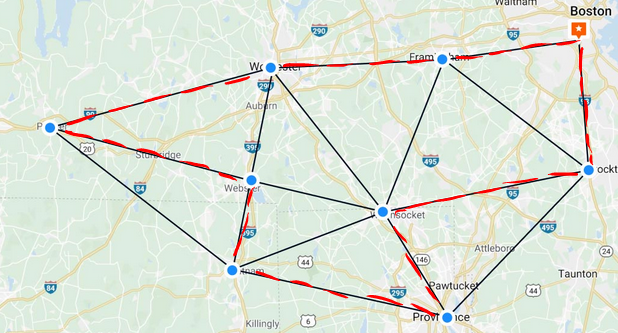

<i>Eine mögliche Rundreise (rot markiert) von Boston nach Boston</i>

<h3>Exkurs: Permutation Flow Shop Scheduling Problem (PFSSP)</h3>
Wie oben kurz angeschintten, basieren auch viele Produktionsplanungsprobleme auf dem TSP. So z.B. das PFSSP. Hierbei geht es darum, in welcher Reihenfolge Fertigungsaufträge (Jobs) in eine Produktionslinie eingelastet werden. Es ist somit ein Ablaufplanungsproblem für Reihen- oder Fließfertigungssysteme mit einer hohen räumlichen Kopplung. Das bedeutet, dass n Jobs m Arbeitsstationen in der gleichen Reihenfolge besuchen müssen. Darüber hinaus können sich die Jobs nicht gegenseitig überholen (siehe Gantt-Diagramm weiter unten). Folglich kann die Reihenfolgeentscheidung nur ganz am Anfang getroffen werden (=Permutierungsproblem)


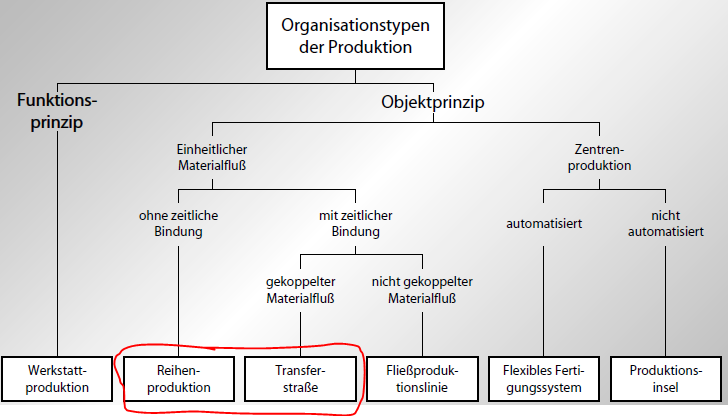

<i>Organisationstypen nach Günther/Tempelmeier: Produktion und Logistik, 6. Auflage, S. 13. Permutation Flow Shops können in den rot markierten Produktionstypen verortet werden</i>

Das Ergebnis des PFSSP (Reihenfolgeplan) kann als Gantt-Diagramm dargestellt werden. Die Reihenfolgeentscheidung kann nur an Station M1 getroffen werden. Je nach Entscheidung hat dies einen Effekt auf die Stillstandzeiten an den nachfolgenden Stationen.

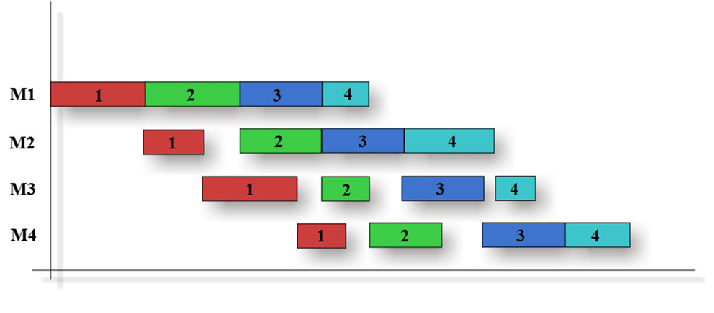

<i>Gantt-Diagramm für ein PFSSP mit 4 Jobs und 4 Stationen.</i>

<h3>Grundprinzip genetischer Algorithmen (GA)</h3>

GA ist die zentrale Algorithmenfamilie, die in pymoo Anwendung findet. GA sind populationsbasierte Metaheuristiken, die auf Basis mehrere Lösungen arbeiten. Im Gegensatz dazu gibt es noch trajektionsbasierte Verfahren, die auf Basis von einer einzelnen Lösung eine Suchstrategie anwenden (z.B. Simulated Annealing). Die Funktionsweise von GA basiert grob auf dem Konzept der Evolution.

Dies ist der elementare Programmablauf von genetischen Algorithmen:
- Zuerst wird eine initiale Population von k verschiedenen (z.B. zufälligen) Individuen (Synonym: Genome, Chromosome) erstellt
- Jedes Individuen setzt sich dabei aus einer Anordnung von Genen zusammen, welche Rückschluss auf die Fitness des Individuums gibt
    - Für ein TSP kann ein Individuum x bspw. folgendermaßen strukturiert sein: x = ["Hamburg", "Berlin", "München", "Köln", "Hamburg"]
    - x hat in diesem Fall 5 Gene, welche jeweils ein Zwischenziel der Rundreise abbilden. Die Reihenfolge der Gene bestimmt die Wegstrecke (=Fitness).
- Dann wird jedes Individuum evaluiert: Die Güte (Fitness) der Lösung wird ausgerechnet. Dies kann z.B. mithilfe eines Simulationsmodells erfolgen.
- Dann läuft die Evolution solange, bis ein Haltekriterium erreicht wird. Dies kann z.B. eine definierte Anzahl an Generationen (Iterationen) sein.
- In jeder Generation passiert folgendes:
    - Es werden die fittesten Individuen der Elternpopulation ausgewählt (vgl. "Survival of the fittest")
    - Diese werden dann zufälllig zu einer gewissen Wahrscheinlichkeit kombiniert (=gepaart, man spricht auch von Crossover)
    - Alternativ mutieren einzelne Individuen zu einer gewissen Wahrscheinlichkeit
    - Die Menge an mutierten Eltern und erzeugten Nachkommen bildet die Basis für die nächste Elterngeneration


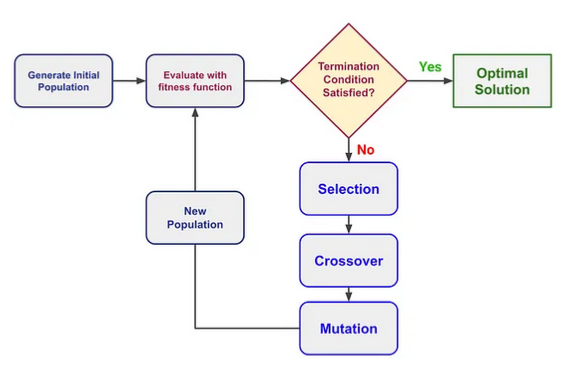

Hier findest du weiterführende allgemeine Grundlagen über Metaheuristiken und genetische Algorithmen:
- https://towardsdatascience.com/genetic-algorithm-a-simple-and-intuitive-guide-51c04cc1f9ed

<h3>Lange Rede, kurzer Sinn...</h3>
Der pymoo-relevante Code wird nun sukzessive erläutert, damit ein TSP gelöst werden kann.

<h3>Die TSP-Eingabe</h3>

Zunächst einmal muss die Eingabe des Problems definiert werden. Man startet mit n Städten, zu denen eine vollständige zufällige Distanzmatrix generiert wird. Ergo wird ein vollständiger gerichteter Graph erzeugt:

In [3]:
import numpy as np

n_cities = 3
distances = np.random.rand(n_cities, n_cities)
distances

array([[0.31008267, 0.30838214, 0.46308708],
       [0.00761263, 0.47011065, 0.54995971],
       [0.96484531, 0.98132781, 0.66367485]])

<h3>Die Definition des Problems</h3>

Nun wird der intiale pymoo Code aufgebaut. Dazu müssen wir zunächst eine Klasse für unser Problem definieren.
Dabei wird von einem ElementwiseProblem abgeleitet. Hier werden die erzeugten Lösungen nacheinander mittels einer Evaluationsfunktion bewertet.

<h5>Konstruktor</h5>

- Dem Konstruktor werden die Anzahl der Städe sowie die erstelle Distanzmatrix übergeben (=Grundlegende Eingabe des Problems)
- Die Anzahl Städte entspricht der Anzahl Variablen (n_var)
- Es wird genau 1 Optimierungsziel (n_obj) gewählt. Dies ist die Minimierung der Gesamtdistanz (siehe Evaluationsfunktion)

<h5>Evaluationsfunktion</h5>

- Die Funktion wird jedes mal von der Bibliothek aufgerufen, wenn die Fitness eines Individuums berechnet werden soll. Dies findet also mehrfach über alle Generationen statt.
- Sie hat zwei wesentliche Parameter: x und out
- x ist das Individuum, welches berechnet werden soll
- In out wird der errechnete Fitnesswert gespeichert

In [4]:

from pymoo.core.problem import ElementwiseProblem

# Klasse des Problems, abgeleitet (geerbt) von ElementwiseProblem
class TSP(ElementwiseProblem): 

    # Konstruktur
    def __init__(self, n_cities, distances): 
        super().__init__(n_var=n_cities, n_obj=1, elementwise_evaluation=True)
        self.n_cities = n_cities
        self.distances = distances

    # Evaluationsfunktion
    def _evaluate(self, x, out, *args, **kwargs): 
        # Berechne die Gesamtdistanz zwischen der Anordnung der Städte, wie sie im Individuum x vorliegt
        distance = np.sum([self.distances[x[i], x[i+1]] for i in range(self.n_cities-1)])

        # Speichere die Distanz im out-Dictionary
        out["F"] = distance


Nun Erzeugen wir eine Instanz des Problems mit einem zufälligen Distanzgraphen über 12 Städte:

In [8]:
n_cities = 12
distances = np.random.rand(n_cities, n_cities)
simple_tsp_problem = TSP(n_cities, distances) # Instanziiere das Problem (Lösung folgt später)

<h3>Die algorithmische Lösung</h3>
Nun wird ein NSGA2-Algorithmus (moderne Version eines GA) verwendet, um das Problem zu lösen:

In [12]:
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

algorithm =  NSGA2(
        # Jede Population umfasst stets 25 Individuen
        pop_size=25,
        # Sampling (=Initialisierung). Diese Methode wird ganz am Anfang des GA ausgeführt um die Basispopulation zu erzeugen.
        # In diesem Fall werden zufällige Rundreisen generiert.
        sampling=PermutationRandomSampling(),
        # Standardfunktion der Bibliothek für die Paarung (siehe https://pymoo.org/operators/index.html)
        # (90% Paarungswahrscheinlichkeit)
        crossover=OrderCrossover(prob=0.9),
        # Standardfunktion der Bibliothek für die Mutierung (siehe https://pymoo.org/operators/index.html)
        # (10% Mutationswahrscheinlichkeit)
        mutation=InversionMutation(prob=0.1),
        # Verwerfe redundante Individuen (spart Rechenzeit)
        eliminate_duplicates=True,
    )

# Führe nun den Algorithms für das Problem aus:
result = minimize(simple_tsp_problem,
                algorithm,
                ('n_gen', 7), # Stopping-Kriterium ist eine festgelegte Anzahl an Generationen (7)
                seed=1,
                verbose=True) # Printe Ergebnisse pro Generation
                
print("Beste Rundreise: ", result.X)
print("Ermittelte Distanz: ", result.F)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       25 |      1 |             - |             -
     2 |       50 |      1 |  0.2668493985 |         ideal
     3 |       75 |      1 |  0.5165347009 |         ideal
     4 |      100 |      1 |  0.5336199724 |         ideal
     5 |      125 |      1 |  0.000000E+00 |             f
     6 |      150 |      1 |  0.000000E+00 |             f
     7 |      175 |      1 |  0.4259431249 |         ideal
Beste Rundreise:  [ 1  7  0  8 10  5  3 11  2  9  6  4]
Ermittelte Distanz:  [2.82113544]


<h3>Überschreiben des Printings pro Generation</h3>

Es ist möglich, sog. Callback-Funktionen zu definieren, die in jeder Generation aufgerufen werden, um z.B. irgendwelche Anpassungen oder Ausgaben vorzunehmen.
Nachfolgend ein Beispiel, wie die Ausgabe pro Generation angepasst werden kann:

In [15]:
from pymoo.core.callback import Callback

# Callback-Klasse, deren Objekt jede Generation aufgerufen wird:
class PrintFittestEachGenCallback(Callback):
    def update(self, algorithm):
        print("Generation: %s | Kürzeste Distanz (fittest): %s" % (algorithm.n_gen, algorithm.pop.get("F").min()))
   
result = minimize(simple_tsp_problem,
                algorithm,
                ('n_gen', 7),
                seed=1,
                verbose=False, # Deaktiviere das Standard-Printing
                callback=PrintFittestEachGenCallback()) # ... und hänge stattdessen den Callback ein
                
print("Beste Rundreise: ", result.X)
print("Ermittelte Distanz: ", result.F)

Generation: 1 | Kürzeste Distanz (fittest): 4.5640826363673845
Generation: 2 | Kürzeste Distanz (fittest): 4.297233237902377
Generation: 3 | Kürzeste Distanz (fittest): 3.7806985370312534
Generation: 4 | Kürzeste Distanz (fittest): 3.2470785646351397
Generation: 5 | Kürzeste Distanz (fittest): 3.2470785646351397
Generation: 6 | Kürzeste Distanz (fittest): 3.2470785646351397
Generation: 7 | Kürzeste Distanz (fittest): 2.8211354397723443
Beste Rundreise:  [ 1  7  0  8 10  5  3 11  2  9  6  4]
Ermittelte Distanz:  [2.82113544]


<h3>Selbstdefinierte Operatoren</h3>
Auf die folgende Art und Weise können eigene Mutationen, Paarungen und Samplingmethoden definiert werden:

In [21]:
from pymoo.core.mutation import Mutation
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
import random as rnd

# CityFlipMutation tauscht zwei zufällige Positionen im Individuum
# Beispiel: [1,2,4,3] -> [1,2,3,4]
class CityFlipMutation(Mutation):
    def _do(self, problem, X, **kwargs):
        # Die gesamte Elternpopulation X wird kopiert. Dann wird werden für jedes Individuum zwei zufällige Positionen in der Permutierung vertauscht.
        Y = np.copy(X)
        for y in Y:
            pos1,pos2 = rnd.sample(list(range(problem.n_cities)), k=2)
            y[pos1], y[pos2] = y[pos2], y[pos1]
        return Y

# CityOrderCrossover kombiniert zwei Städte nach dem Prinzip des sog. (Job) Order Crossovers.
# Zur Erklärung siehe Abbildung unten
class CityOrderCrossover(Crossover):

    # Dieser Konstruktor bezweckt, dass auf Basis von zwei Elternteilen zwei Kinder erzeugt werden
    def __init__(self):
        super().__init__(n_parents=2, n_offsprings=2)

    def _do(self, problem, all_parents, **kwargs):

        # Untermethode zur Erzeugung eines Kindes
        def get_one_child(par1,par2):
            ch = [None] * problem.n_cities # Leeres Kind mit der "Größe" von n Genen (=Anzahl Städte)
            cities_from_par1 = rnd.sample(par1, k=rnd.randint(1,problem.n_cities-1)) # wähle zufällige Gene aus Elternteil1
            for c in cities_from_par1: # ... und übertrage sie positionsgetreu in das Kind
                ch[par1.index(c)] = c
            cities_from_par2 = list(set(par2).difference(cities_from_par1)) # Ermittle die übrigen zu übertragenden Gene
            for i in range(len(ch)):
                if ch[i] == None:
                    ch[i] = cities_from_par2.pop(0) # und schreibe sie auf die verbleibenden leeren Positionen des Kindes
            return ch
        
        n_matings = len(all_parents[0]) # Anzahl Eltern-Pärchen
        Y = [[],[]] # Kind-Liste mit zwei Untereinträgen (Geschwisterkind1 und Geschwisterkind2)
        for i in range(n_matings):
            # Extrahiere die aktuellen Eltern gem. i
            parent1 = list(all_parents[0][i])
            parent2 = list(all_parents[1][i]) 
            # ... und erzeuge zwei Kinder auf Basis unterschiedlicher Elternkonstellationen
            Y[0].append(get_one_child(parent1,parent2))
            Y[1].append(get_one_child(parent2,parent1))
        return np.array(Y)

# Zufälliges Sampling (selbstgebaute Funktion)
class PermutationRandomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_var), 0, dtype=int)
        for i in range(n_samples):
            X[i, :] = np.random.permutation(problem.n_var)
        return X

So funktioniert die Paarung von Eltern nach dem OrderCrossover (vielfach verwendete Paarungsfunktion im Scheduling-Bereich):
- Es werden zufällige Gene des 1. Elternteils ausgewählt und positionsgetreu ins Kind übertragen (orange)
- Die übrigen Gene werden aus Elternteil 2 extrahiert und in der Reihenfolge ins Kind gefüllt (blau)

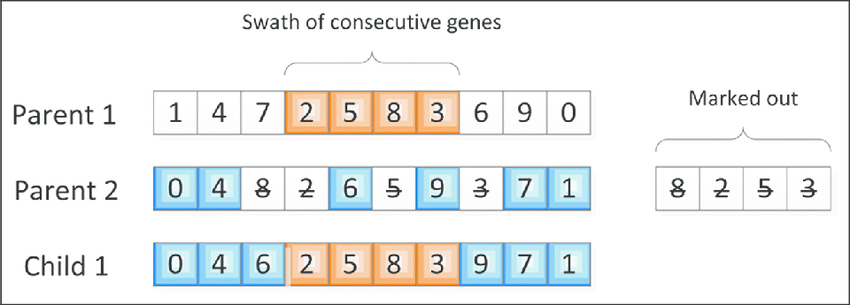

<i>Order Crossover</i>

<h3>Adaptive Crossover- und Mutationswahrscheinlichkeiten</h3>
Darüber hinaus verwenden wir den oben definierten Callback und erweitern ihn: Anstatt fixer Crossover- und Mutationswahrscheinlichkeiten sollen die Raten linear angepasst werden. Am Anfang ist die Crossoverrate geringt, steigt aber mit der Anzahl Generationen. Bei der Mutationsrate ist es umgekehrt.

In [80]:
class EachIterationCallback(Callback):
    def __init__(self, max_gen):
        self.max_gen = max_gen
        super().__init__()

    def update(self, algorithm):
        algorithm.mating.crossover.prob.value = algorithm.n_gen / self.max_gen # Linear steigend
        algorithm.mating.mutation.prob.value = 1 - algorithm.mating.crossover.prob.value # Linear sinkend
        print("Generation: %s | Crossoverwahrsch.: %s, Mutationswahrsch.: %s | Fittest: %s" \
              % (algorithm.n_gen, algorithm.mating.crossover.prob.value, algorithm.mating.mutation.prob.value, algorithm.pop.get("F").min()))

<h3>Test der neuen Algorithmus-Konfiguration</h3>
Testen wir nun den Algorithmus mit den neuen selbstdefinierten Funktionen:

In [81]:
algorithm = NSGA2(
        pop_size=25,
        sampling=PermutationRandomSampling(),
        crossover=CityOrderCrossover(),
        mutation=CityFlipMutation(),
        eliminate_duplicates=True
    )

max_gen = 15
result = minimize(simple_tsp_problem,
                    algorithm,
                    ('n_gen', max_gen),
                    seed=1,
                    verbose=False,
                    callback=EachIterationCallback(max_gen))

print("Beste Rundreise: ", result.X)
print("Ermittelte Distanz: ", result.F)

Generation: 1 | Crossoverwahrsch.: 0.06666666666666667, Mutationswahrsch.: 0.9333333333333333 | Fittest: 4.0585826334696
Generation: 2 | Crossoverwahrsch.: 0.13333333333333333, Mutationswahrsch.: 0.8666666666666667 | Fittest: 3.219992906042788
Generation: 3 | Crossoverwahrsch.: 0.2, Mutationswahrsch.: 0.8 | Fittest: 3.219992906042788
Generation: 4 | Crossoverwahrsch.: 0.26666666666666666, Mutationswahrsch.: 0.7333333333333334 | Fittest: 3.219992906042788
Generation: 5 | Crossoverwahrsch.: 0.3333333333333333, Mutationswahrsch.: 0.6666666666666667 | Fittest: 3.219992906042788
Generation: 6 | Crossoverwahrsch.: 0.4, Mutationswahrsch.: 0.6 | Fittest: 3.219992906042788
Generation: 7 | Crossoverwahrsch.: 0.4666666666666667, Mutationswahrsch.: 0.5333333333333333 | Fittest: 3.219992906042788
Generation: 8 | Crossoverwahrsch.: 0.5333333333333333, Mutationswahrsch.: 0.4666666666666667 | Fittest: 3.219992906042788
Generation: 9 | Crossoverwahrsch.: 0.6, Mutationswahrsch.: 0.4 | Fittest: 3.2092019

<h3>Mehrfache Zielsetzung</h3>
Bislang haben wir ein TSP mit einfacher Zielsetzung betrachtet (minimiere Gesamtdistanz). pymoo erlaubt jedoch auch multikriterielle Optimierung, welche benutzerfreundlich implementiert werden kann.
Nachfolgend sollen 2 Ziele betrachtet werden. Neben Minimierung der Gesamtdistanz soll zudem noch die erste Etappe minimiert werden.
Dies führt unter Umständen zu Zielkonflikten: Die Verbesserung des einen Ziels kann eine Verschlechterung des anderen Ziels ergeben (Pareto-effiziente Ziele). Aus diesem Grund muss am Ende des Verfahrens eine Kompromisslösung ausgewählt werden.

Hier erfährst du mehr über das Grundprinzip der Pareto-Optimierung:
- https://medium.com/@chongjingting/multi-objective-optimization-moo-1b29ece5b64f

Definieren wir zunächst eine neue TSP-Klasse für multikriterielle Optimierung mit den zwei o.g. Zielen (n_obj=2):

In [82]:
class TSP_Multi(ElementwiseProblem):

    def __init__(self, n_cities, distances):
        super().__init__(n_var=n_cities, n_obj=2, elementwise_evaluation=True)
        self.n_cities = n_cities
        self.distances = distances

    def _evaluate(self, x, out, *args, **kwargs):
        # Fitnesswert 1 (Gesamtdistanz)
        overall_distance = np.sum([self.distances[x[i], x[i+1]] for i in range(self.n_cities-1)])
        # Fitnesswert 2 (Distanz der 1. Etappe zwischen erster und zweiter Stadt)
        first_lap_distance = self.distances[x[0], x[1]]
        # Speichere beide Fitnesswerte in die folgende Liste:
        out["F"] = [overall_distance,first_lap_distance]

Instanziieren wir nun das neue Problem. Wir verwenden wieder n Städte und eine zufällig generierte Distanzmatrix:

In [83]:
n_cities = 100
distances = np.random.rand(n_cities, n_cities)
problem_multi_tsp = TSP_Multi(n_cities, distances)

<h3>Normalisierung und Auswahl einer Kompromisslösung</h3>

Die folgende Funktion berechnet nun die bestmögliche Lösung für ein Modell auf Basis eines gewählten Algorithmus. 

Zudem kann die Anzahl Generationen angegeben werden, wie lange das Verfahren läuft. Und es könne Gewichte (Prioritäten) für die Ziele definiert werden. Im folgenden Beispiel wird das 1. Ziel mit 80% gewichtet und das zweite Ziel mit 20%. Die Funktion verwendet dabei Normalisierungsfunktionen und wählt mittels der sog. Augmented Scalarization Function  (ASF) eine Lösung in der Paretofront aus, welche der Priorisierung nahekommt.

In [84]:
from pymoo.decomposition.asf import ASF

def run_algorithm_and_get_best(algorithm,problem,max_gen=8,weights=[0.8,0.2],seed=None):
    res = minimize(problem,
                    algorithm,
                    ('n_gen', max_gen),
                    seed=seed,
                    verbose=False,
                    callback=EachIterationCallback(max_gen))

    # Normalisiere die gefundenen Lösungen.
    # In der Pareto-Optimierung geht es darum, ein Optimum zu finden, das das beste Ergebnis für alle beteiligten Ziele oder Kriterien liefert, 
    # ohne dass eines der Ziele auf Kosten eines anderen optimiert wird. Das bedeutet, dass es oft mehrere mögliche Lösungen gibt, 
    # die alle verschiedene Abwägungen zwischen den Zielen treffen.
    # Das Normalisieren der Lösungen ist in der Pareto-Optimierung wichtig, um sicherzustellen, dass jede Lösung fair und gleichberechtigt bewertet wird, 
    # unabhängig von der Skala oder Einheit, in der die einzelnen Ziele gemessen werden. 
    # Ohne Normalisierung könnten bestimmte Ziele mit höheren Skalen oder Einheiten bevorzugt werden und damit das Ergebnis der Pareto-Optimierung beeinflussen.
    F_norm = (res.F - res.F.min(axis=0)) / (res.F.max(axis=0) - res.F.min(axis=0))

    # Extrahiere mit ASF nun die beste Lösung auf Basis der normalisierten Werte (siehe https://pymoo.org/getting_started/part_3.html)
    i_best = ASF().do(F_norm, 1/np.array(weights)).argmin()

    print("Beste Rundreise: ", res.X[i_best])
    print("Ermittelte Distanz: ", res.F[i_best])
    print(f"Rechenzeit: {res.exec_time} s")

    return res, res.X[i_best], res.F[i_best]

result, best_trip, best_distance = run_algorithm_and_get_best(NSGA2(
        pop_size=25,
        sampling=PermutationRandomSampling(),
        crossover=CityOrderCrossover(),
        mutation=CityFlipMutation(),
        eliminate_duplicates=True,
    ), problem=problem_multi_tsp)

Generation: 1 | Crossoverwahrsch.: 0.125, Mutationswahrsch.: 0.875 | Fittest: 0.08141737500067137
Generation: 2 | Crossoverwahrsch.: 0.25, Mutationswahrsch.: 0.75 | Fittest: 0.08141737500067137
Generation: 3 | Crossoverwahrsch.: 0.375, Mutationswahrsch.: 0.625 | Fittest: 0.08141737500067137
Generation: 4 | Crossoverwahrsch.: 0.5, Mutationswahrsch.: 0.5 | Fittest: 0.08141737500067137
Generation: 5 | Crossoverwahrsch.: 0.625, Mutationswahrsch.: 0.375 | Fittest: 0.0058809814446282305
Generation: 6 | Crossoverwahrsch.: 0.75, Mutationswahrsch.: 0.25 | Fittest: 0.0058809814446282305
Generation: 7 | Crossoverwahrsch.: 0.875, Mutationswahrsch.: 0.125 | Fittest: 0.0058809814446282305
Generation: 8 | Crossoverwahrsch.: 1.0, Mutationswahrsch.: 0.0 | Fittest: 0.0058809814446282305
Beste Rundreise:  [95 69 41 28 54 58 65 50 26 35 92 12  4 99 91  8 33  5 93  0 20 62 43 59
 67 74 71 18 23  9  1  2 70 46 84 49 82 22 37 94 10 77 19 76  7 27 89 68
 61 44 63 14 24 21 45 60 83 48 75 30 17 34 81 11 47 78 8

<h3>Parallelisierung</h3>

Um die Rechenperformanz des Verfahrens weiter zu verbessern, kann der Algorithmus auf mehrere Rechenprozesse oder Threads parallelisiert werden. Dies regelt pymoo weitgehend "unter der Haube".

Dazu erstellen wir eine neue Problemklasse, die dieses mal einen sog. runner erhalten kann. Dieser steuert die Parallelisierung.


In [85]:
import time

class TSP_Multi_Parallel(ElementwiseProblem):

    def __init__(self, n_cities, distances, runner, sleep_for_test=False):
        # leite den Runner an die Basisklasse weiter:
        super().__init__(n_var=n_cities, n_obj=2, elementwise_evaluation=True, elementwise_runner=runner)
        self.n_cities = n_cities
        self.distances = distances

        # dieses Feld dient Testzwecken: Es soll eine lange Rechenoperation "simuliert" werden, indem
        # das Verfahren in der Evaluationsfunktion (siehe unten) eine Sekunde anhält. 
        # Dies zeigt später den Effekt der Parallelisierung.
        self.sleep_for_test = sleep_for_test 

    def _evaluate(self, x, out, *args, **kwargs):
        overall_distance = np.sum([self.distances[x[i], x[i+1]] for i in range(self.n_cities-1)])
        first_lap_distance = self.distances[x[0], x[1]]
        out["F"] = [overall_distance,first_lap_distance]
        if self.sleep_for_test:
            time.sleep(1)

Es stehen grundsätzlich drei Möglichkeiten zur Parallelisierung zur Verfügung: Multithreading, Multiprocessing und Dask. Siehe: https://pymoo.org/problems/parallelization.html

Nachfolgend eine Implementierung für Multithreading und zunächst mit einem einzelnen Thread:

In [86]:
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization

n_cities = 60
distances = np.random.rand(n_cities, n_cities)

with ThreadPool(1) as pool: # 1 Thread
    runner = StarmapParallelization(pool.starmap)
    problem_multi_tsp_parallel = TSP_Multi_Parallel(n_cities, distances, runner, sleep_for_test=True) # halte in jeder Evaluation 1 Sekunde an
    run_algorithm_and_get_best(NSGA2(
            pop_size=3,
            sampling=PermutationRandomSampling(),
            crossover=CityOrderCrossover(),
            mutation=CityFlipMutation(),
            eliminate_duplicates=True,
        ), problem=problem_multi_tsp_parallel, max_gen=3, seed=None)

Generation: 1 | Crossoverwahrsch.: 0.3333333333333333, Mutationswahrsch.: 0.6666666666666667 | Fittest: 0.8863737364923805
Generation: 2 | Crossoverwahrsch.: 0.6666666666666666, Mutationswahrsch.: 0.33333333333333337 | Fittest: 0.04445258057107482
Generation: 3 | Crossoverwahrsch.: 1.0, Mutationswahrsch.: 0.0 | Fittest: 0.04445258057107482
Beste Rundreise:  [ 7 10 40 39 14 43 51  4  2 26 47  3 58 31 50 37  0 19 20 16 56 44 59  9
 46 32 41 27 52 36  6 23 34 28 24 45  1 29 17 42 54  5 15 30 25 13 33 55
 35 12 53 22 49 38 21 57 48 18 11  8]
Ermittelte Distanz:  [25.24032188  0.94685448]
Rechenzeit: 9.011996269226074 s


Bei langen Evaluationsvorgängen ist die Optimierungsprozedur recht langsam... Probieren wir nun dasselbe mit 4 parallelen Threads:

In [87]:
with ThreadPool(4) as pool: # 4 Threads
    runner = StarmapParallelization(pool.starmap)
    problem_multi_tsp_parallel = TSP_Multi_Parallel(n_cities, distances, runner, sleep_for_test=True)
    run_algorithm_and_get_best(NSGA2(
            pop_size=3,
            sampling=PermutationRandomSampling(),
            crossover=CityOrderCrossover(),
            mutation=CityFlipMutation(),
            eliminate_duplicates=True,
        ), problem=problem_multi_tsp_parallel, max_gen=3, seed=None)

Generation: 1 | Crossoverwahrsch.: 0.3333333333333333, Mutationswahrsch.: 0.6666666666666667 | Fittest: 0.23685727335179396
Generation: 2 | Crossoverwahrsch.: 0.6666666666666666, Mutationswahrsch.: 0.33333333333333337 | Fittest: 0.23685727335179396
Generation: 3 | Crossoverwahrsch.: 1.0, Mutationswahrsch.: 0.0 | Fittest: 0.22275407975135053
Beste Rundreise:  [26 59 16 31 48 57 25  3 22  6 34 45  2 15 54 35  7 37 20 47 44 27 41 13
 55 46 51 36  9 42 38  5 33 10  0 19  4  8 29 40 11 21 32  1 30 49 43 17
 28 50 24 58 18 12 52 39 56 53 14 23]
Ermittelte Distanz:  [25.97041861  0.23685727]
Rechenzeit: 3.0085837841033936 s


<h3>Hyperparameter Tuning</h3>
Genetische Algorithmen haben einige Hyperparameter. Dazu gehören insbesondere:

- Die Anzahl an Generationen
- Die Größe der Population
- Die Crossover-/Mutationswahrscheinlichkeit
- Die Art und Weise des Samplings (Initialisierung), des Crossovers und der Mutation

In pymoo kann dies über ein eigenes HyperparameterProblem umgesetzt werden. Dies ist im Grunde ein eigenes Optimierungsproblem, welches eine geeignete Einstellung für ein Verfahren findet.

Nachfolgend ein simples Beispiel, wir für das initial erstelle TSP-Problem (singuläres Ziel) in Kombination mit dem NSGA2-Algorithms eine passende Hyperparametrisierung gefunden wird:

In [88]:
from pymoo.algorithms.hyperparameters import HyperparameterProblem, MultiRun, stats_single_objective_mean
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.parameters import set_params, hierarchical

algorithm_to_tune = NSGA2(
                sampling=PermutationRandomSampling(),
                crossover=CityOrderCrossover(),
                mutation=CityFlipMutation(),
                eliminate_duplicates=True
        )
problem = TSP(n_cities=66, distances=np.random.rand(66, 66))
seeds = [5, 50, 500]

performance = MultiRun(problem, seeds=seeds, func_stats=stats_single_objective_mean, termination=("n_evals", 250))
res = minimize(HyperparameterProblem(algorithm_to_tune, performance),
               MixedVariableGA(pop_size=10),
               termination=('n_evals', 50),
               seed=1,
               verbose=True)
hyperparams = res.X
print(hyperparams)

set_params(algorithm_to_tune, hierarchical(hyperparams)) # Setze nun die gefundenen Hyperparameter

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.587739E+01 |  2.532543E+01
     2 |       20 |  2.568789E+01 |  2.532543E+01
     3 |       30 |  2.559545E+01 |  2.532543E+01
     4 |       40 |  2.549678E+01 |  2.532543E+01
     5 |       50 |  2.546023E+01 |  2.532543E+01
{'mating.mutation.prob': 0.8251066014107722, 'mating.crossover.prob': 0.7095972572016473}


<h3>Standardisierter Code</h3>

Nun werden die in diesem Notebook vorgestellten Konzepte wiederverwertber standardisiert.

In [ ]:
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.rvea import RVEA
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.core.repair import Repair
from pymoo.util.reference_direction import default_ref_dirs


def get_alg(name, n_objectives, crossover, mutation, sampling, duplicate_elimination):
    assert n_objectives <= 3, 'currently, max. 3 objectives are allowd. please configure custom ref_dirs (see code below), to enable more objectives'
    
    # wichtig für many objectives verfahren. es können max. n=3 ziele definiert sein.
    # darüber hinaus kann die default funktion nicht verwendet werden. die ref_dirs müssen selbst definiert werden.
    # https://github.com/anyoptimization/pymoo/blob/main/pymoo/util/reference_direction.py
    ref_dirs = default_ref_dirs(n_objectives)  
    
    repair = Repair()

    if name == 'moead': # Well-known multi-objective optimization algorithm based on decomposition.
        return MOEAD( 
            ref_dirs=ref_dirs, # defines pop_size via ref_dirs
            sampling=sampling,
            crossover=crossover,
            mutation=mutation
        )
    if name == 'nsga2': # Well-known multi-objective optimization algorithm based on non-dominated sorting and crowding.
        return NSGA2( 
            sampling=sampling,
            crossover=crossover,
            mutation=mutation,
            eliminate_duplicates=duplicate_elimination,
        )
    if name == 'rvea': # A reference direction based algorithm used an angle-penalized metric.
        return RVEA( 
            ref_dirs=ref_dirs,
            sampling=sampling,
            crossover=crossover,
            mutation=mutation,
            eliminate_duplicates=duplicate_elimination,
        )
    if name == 'ctaea': # An algorithm with a more sophisticated constraint-handling for many-objective optimization algoritms.
        return CTAEA( 
            ref_dirs=ref_dirs,
            sampling=sampling,
            crossover=crossover,
            mutation=mutation,
            eliminate_duplicates=duplicate_elimination
        )
    if name == 'unsga3': # A generalization of NSGA-III to be more efficient for single and bi-objective optimization problems.
        return UNSGA3( 
            ref_dirs=ref_dirs,
            sampling=sampling,
            crossover=crossover,
            mutation=mutation,
            eliminate_duplicates=duplicate_elimination,
        )
    raise Exception(f'{name} is not a defined algorithm')
    # wenn erfordert, können auch weitere verfahren hinzugefügt werden...

In [89]:
import multiprocessing
from multiprocessing.pool import ThreadPool

import numpy as np
from dask.distributed import Client
from pymoo.core.problem import DaskParallelization, StarmapParallelization
from pymoo.decomposition.asf import ASF
from pymoo.optimize import minimize


def run_alg_parallel(run_alg_caller, param):
    if param['parallelization_method'] == 'dask':
        with Client() as client:
            client.restart()
            return run_alg_caller(param, DaskParallelization(client))
    elif param['parallelization_method'] == 'multi_threading':
        with ThreadPool(param['n_parallelizations']) as pool:
            return run_alg_caller(param, StarmapParallelization(pool.starmap))
    elif param['parallelization_method'] == 'multi_processing':
        with multiprocessing.Pool(param['n_parallelizations']) as pool:
            return run_alg_caller(param, StarmapParallelization(pool.starmap))
    else:
        raise Exception(f'{param["parallelization_method"]} is not a valid parallelization method')


def run_alg(param, runner=None):
    # instantiate algorithm and problem to optimize
    probl = param['problem_getter'](param,runner)
    alg = get_alg(param['alg_name'], n_objectives=len(param['obj_weights']), 
                    crossover=param['crossover'], mutation=param['mutation'], 
                    sampling=param['sampling'], duplicate_elimination=param['eliminate_duplicates']) # TODO: hyperparameter tuning
    
    res = minimize(probl,
                    alg,
                    ('n_eval', param['n_evals']), # use max evals as stopping criterion
                    seed=param['seed'],
                    callback=EachIterationCallback(param['n_evals'], 
                                                    adaptive_rate_mode=param['adaptive_rate_mode'], # adjust mutation/crossover rates
                                                    print_iteration_stats=param['print_iterations']), # print stats
                    verbose=False, # print additional stats
                )

    # normalize results and select best by weights
    F_normalized = (res.F - res.F.min(axis=0)) / (res.F.max(axis=0) - res.F.min(axis=0))
    i_best = ASF().do(F_normalized, 1/np.array(param['obj_weights'])).argmin()
    
    if param['print_results']:
        print(f"\n{alg}\n=================")
        print("Best solution found: ", res.X[i_best])
        print("Objective value: ", res.F[i_best])
        print(f"Comp. time: {res.exec_time} s")
    
    if param['plot_solution']:
        probl.plot_solution(res.X[i_best])

    return res, res.X[i_best], res.F[i_best]

In [91]:
from pymoo.core.callback import Callback
from pymoo.core.variable import Real
from pprint import pprint

class EachIterationCallback(Callback): # called in each generation/iteraion
    def __init__(self, max_evals, adaptive_rate_mode='none', print_iteration_stats=True):
        self.max_evals = max_evals
        self.print_iteration_stats = print_iteration_stats
        self.adaptive_rate_mode = adaptive_rate_mode
        super().__init__()

    def update(self, algorithm):
        """ 
        icdm: (linearly) increasing crossover & decreasing mutation
        imdc: decr. mutation, incr. crossover
        """

        def get_val(var):
            if isinstance(var, Real):
                return var.value
            elif isinstance(var, float):
                return var
            
        def set_val(var, val):
            if isinstance(var, Real):
                var.value = val
                return var
            elif isinstance(var, float):
                return val

        if self.adaptive_rate_mode == 'icdm':
            algorithm.mating.crossover.prob = set_val(algorithm.mating.crossover.prob, algorithm.evaluator.n_eval / self.max_evals)
            algorithm.mating.mutation.prob = set_val(algorithm.mating.mutation.prob, 1.0-get_val(algorithm.mating.crossover.prob))
        if self.adaptive_rate_mode == 'imdc':
            algorithm.mating.mutation.prob = set_val(algorithm.mating.mutation.prob, algorithm.evaluator.n_eval / self.max_evals)
            algorithm.mating.crossover.prob = set_val(algorithm.mating.crossover.prob, 1.0 - get_val(algorithm.mating.mutation.prob))
        elif self.adaptive_rate_mode != 'none' and self.adaptive_rate_mode != 'static':
            raise Exception(f'{self.adaptive_rate_mode} is not defined.')
        if self.print_iteration_stats:
            print("EVALS: %s | CXPB: %s, MUTPB: %s | FITTEST: %s" % (algorithm.evaluator.n_eval, get_val(algorithm.mating.crossover.prob), \
                get_val(algorithm.mating.mutation.prob), algorithm.pop.get("F").min()))

<h3>TSP mit standardisiertem Code</h3>
Erstellen wir das finale Problem, welches mit dem standardisierten Code kompatibel ist. 
Hierfür müssen wir die Problemklasse auch standardisieren, sodass sie allgemeingültig auf beliebige Probleme übertragbar ist.

Der dafür standardisierte Konstruktor hat zwei Parameter:
- param (Dictionary mit allen Einstellungen für das Modell und für den Algorithmus, die erforderlich sind)
- runner (Multithreading, Multiprocessing oder Dask Konfiguration)

In [92]:
class TSP_Final(ElementwiseProblem):
    def __init__(self, param, runner):
        super().__init__(n_var=param['n_cities'], n_obj=2, elementwise_evaluation=True, elementwise_runner=runner)
        self.n_cities = param['n_cities']
        self.distances = param['distances']
        self.sleep_for_test = param['sleep_for_test'] 

    def _evaluate(self, x, out, *args, **kwargs):
        overall_distance = np.sum([self.distances[x[i], x[i+1]] for i in range(self.n_cities-1)])
        first_lap_distance = self.distances[x[0], x[1]]
        out["F"] = [overall_distance,first_lap_distance]
        if self.sleep_for_test:
            time.sleep(1)

So werden die Parameter (param) für dieses konkrete Problem definiert:

In [93]:
n_cities = 60
param = {
    'problem_getter': TSP_Final, # Die Klasse des Problems
    'n_cities': n_cities, # Spezifische Eingabe für des TSP
    'distances': np.random.rand(n_cities, n_cities), # ...ebenso
    'sleep_for_test': False,
    'alg_name': 'nsga2', # Zu verwendendes Verfahren. Siehe algorithm_factory.py
    'crossover': CityOrderCrossover(),
    'mutation': CityFlipMutation(),
    'sampling': PermutationRandomSampling(),
    'adaptive_rate_mode': 'none', # none | icdm (incr. crossover, decr. mutation) | imdc (incr. mutation, decr. crossover)
    'obj_weights': [0.8,0.2], # Gewichte für die beiden zu optimierenden Zielgrößen
    'n_evals': 200, # Max. Anz. der Evaluationen (Stopping-Kriterium anstelle von max. Anz. Generationen)
    'parallelization_method': 'multi_threading', # multi_threading | multi_processing | dask
    'n_parallelizations': 4, # Anzahl paralleler Prozesse oder Threads
    'eliminate_duplicates': False, # Eliminiere Duplikate (redundante Individuen)
    'seed': None, # Starte mit Zufallszahl
    'print_results': True, # Endergebnis ausgeben
    'print_iterations': True, # Zwischenergebnis ausgeben je Generation/Iteration
    'plot_solution': False, # Diagramm ausgeben
}
result, best_trip, best_distances = run_alg_parallel(run_alg, param)

EVALS: 100 | CXPB: 0.9, MUTPB: 1.0 | FITTEST: 0.01047426755982328
EVALS: 200 | CXPB: 0.9, MUTPB: 1.0 | FITTEST: 0.01047426755982328

Best solution found:  [25  0  1  2  3  4  5  6  7  8  9 10 18 12 13 15 56 41 16 28 17 19 14 20
 21 22 23 24 26 27 29 30 53 32 34 35 36 38 39 40 42 43 44 45 46 47 48 49
 11 33 50 51 52 37 31 54 55 57 58 59]
Objective value:  [25.56730145  0.27138212]
Comp. time: 0.026940584182739258 s


<h3>Lösung eines Permutation Flow Shop Scheduling Problems (PFSSP)</h3>

Nun wird gezeigt, wie das PFSSP (Erklärung siehe am Anfang des Notebooks) mithilfe des standardisierten Codes gelöst werden kann.

<h5>Schritt 1: Eingabe definieren</h5>
Es gibt n Jobs und m Maschinen. Jeder Job muss jede Maschine besuchen. Alle Jobs besuchen die Maschinen in der gleichen Reihenfolge.

Jeder Job hat eine spezifische Bearbeitungszeit auf jeder Maschine. Z.B. J1M1: 5 Zeiteinhheiten, J1M2: 3 ZE, J1M3: 4 ZE, J2M1: 2 ZE usw.

In [94]:
n_jobs = 5
n_machines = 2
processing_times = np.random.rand(n_jobs, n_machines)
processing_times

array([[0.98261628, 0.59277466],
       [0.1587812 , 0.02234155],
       [0.46919584, 0.39517383],
       [0.61764174, 0.17814808],
       [0.1729802 , 0.66360049]])

<h5>Schritt 2: Ausgabe und Evaluation definieren</h5>
Letztendlich soll ein Produktionsplan erzeugt werden, der z.B. in Form eines Gantt-Diagramms visualisiert werden kann.
Dies kann z.B. über ein komplexes Simulationsmodell geschehen, welches viele Nebenbedingungen berücksichtigt und die Realität realistisch abbildet.

In unserem Fall reicht jedoch eine kleine Funktion um einen Schedule zu erzeugen:

In [95]:
def generate_schedule(ind, n_machines, processing_times): # Übergeben wird ein Individuum für das PFSSP (Permutierung der einzulastenden Jobs), z.B. J1, J2, J4, J3
    # Baue den Schedule Stück für Stück auf. Verplane dabei jeden Job auf jeder Maschine.
    job_machine_assignments = []
    for job_idx in ind:
        for machine_idx in range(n_machines):
            # Extrahiere alle potenziellen Vorgängeroperationen
            predecessors = list(filter(lambda p: p['resource'] <= machine_idx, job_machine_assignments))
            # Extrahiere aus diesen wiederrum den letzten End-Termin, welcher gleichzeitig der Starttermin des aktuellen Jobs ist
            start_time = max(list(map(lambda p: p['end_time'], predecessors))) if job_machine_assignments else 0
            # Erzeuge den Eintrag für den Schedule
            job_machine_assignments.append({
                    'start_time': start_time, 
                    'end_time': start_time + processing_times[job_idx,machine_idx], 
                    'job': job_idx, 
                    'resource': machine_idx
                })
            
    # Gebe das Ergebnis (Start- und Endzeitpunkt je zugewiesenen Job) zurück, um z.B. ein Gantt-Diagramm zu erzeugen
    return job_machine_assignments

Definieren wir ein zufälliges Individuum anhand der bereits angelegten Processing-Time-Matrix:

In [96]:
dummy_ind = [0,1,2,3,4] # Job-Indizes in der Reihenfolge, wie sie in die Produktionslinie eingelastet werden

schedule_info = generate_schedule(dummy_ind, n_machines, processing_times)
schedule_info

[{'start_time': 0, 'end_time': 0.9826162836700122, 'job': 0, 'resource': 0},
 {'start_time': 0.9826162836700122,
  'end_time': 1.5753909486677125,
  'job': 0,
  'resource': 1},
 {'start_time': 0.9826162836700122,
  'end_time': 1.1413974806044935,
  'job': 1,
  'resource': 0},
 {'start_time': 1.5753909486677125,
  'end_time': 1.5977324994675457,
  'job': 1,
  'resource': 1},
 {'start_time': 1.1413974806044935,
  'end_time': 1.610593319257317,
  'job': 2,
  'resource': 0},
 {'start_time': 1.610593319257317,
  'end_time': 2.005767146572295,
  'job': 2,
  'resource': 1},
 {'start_time': 1.610593319257317,
  'end_time': 2.2282350611941015,
  'job': 3,
  'resource': 0},
 {'start_time': 2.2282350611941015,
  'end_time': 2.4063831419188926,
  'job': 3,
  'resource': 1},
 {'start_time': 2.2282350611941015,
  'end_time': 2.401215258169178,
  'job': 4,
  'resource': 0},
 {'start_time': 2.4063831419188926,
  'end_time': 3.06998362966202,
  'job': 4,
  'resource': 1}]

Und nun als Gantt-Diagramm:

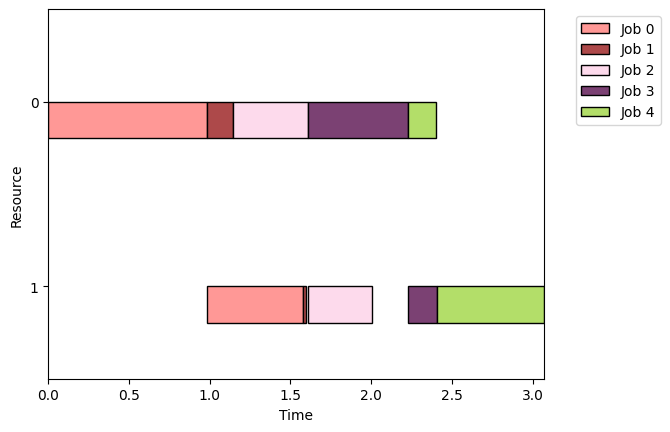

In [97]:
import matplotlib.pyplot as plt
import random

def plot_gantt(tasks):
    # Group tasks by job
    jobs = {}
    for task in tasks:
        job_id = task["job"]
        if job_id not in jobs:
            jobs[job_id] = []
        jobs[job_id].append(task)

    # Define color map for jobs
    job_colors = {}
    colors = (
        ["r", "g", "b", "c", "m", "y", "k"]
        + [plt.cm.tab20(i) for i in range(20)]
        + [plt.cm.Pastel1(i) for i in range(9)]
        + [plt.cm.Set3(i) for i in range(12)]
        + [plt.cm.Accent(i) for i in range(8)]
        + [plt.cm.Dark2(i) for i in range(8)]
        + [plt.cm.Paired(i) for i in range(12)]
        + [plt.cm.tab10(i) for i in range(10)]
        + [plt.cm.tab20b(i) for i in range(20)]
        + [plt.cm.tab20c(i) for i in range(20)]
        + [plt.cm.Set1(i) for i in range(9)]
    )
    for job_id in jobs.keys():
        job_colors[job_id] = random.choice(colors)

    # Plot Gantt chart
    fig, ax = plt.subplots()

    # Set y axis limits and labels
    y_labels = sorted(set([task["resource"] for task in tasks]))
    ax.set_ylim([min(y_labels) - 0.5, max(y_labels) + 0.5])
    ax.set_yticks(y_labels)
    ax.set_yticklabels(y_labels)

    # Set x axis limits and labels
    x_min = min([task["start_time"] for task in tasks])
    x_max = max([task["end_time"] for task in tasks])
    ax.set_xlim([x_min, x_max])
    ax.set_xlabel("Time")
    ax.set_ylabel("Resource")
    
    # Reverse y Axis    
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[1], ylim[0]))

    # Plot tasks
    for task in tasks:
        job_id = task["job"]
        y = task["resource"]
        start = task["start_time"]
        end = task["end_time"]
        duration = end - start

        def is_overlap(task1, task2):
            def is_in_bounds(t1,t2):
                t2_starts_whithin_t1 = t2["start_time"] >= t1["start_time"] and t2["start_time"] < t1["end_time"]
                t2_ends_within_t1 = t2["end_time"] > t1["start_time"] and t2["end_time"] <= t1["end_time"]
                return t2_starts_whithin_t1 or t2_ends_within_t1
            return is_in_bounds(task1,task2) or is_in_bounds(task2,task1)

        def get_overlaps_recurs(tsk, tabu=[], overlaps_found=[]):
            if tsk in tabu:
                return overlaps_found
            tabu.append(tsk)
            ovr = list(filter(lambda t: t["resource"] == tsk["resource"] and is_overlap(tsk, t), tasks))
            for o in ovr:
                if o not in overlaps_found:
                    overlaps_found.append(o)
                    get_overlaps_recurs(o, tabu, overlaps_found)
            return overlaps_found

        overlaps = get_overlaps_recurs(task)
        overlap_idx = list(map(lambda t: tasks.index(t), overlaps)).index(tasks.index(task))
        height = 0.2 / len(overlaps)
        offset = overlap_idx * height
        rect = plt.Rectangle((start, y + offset), duration, height, edgecolor="k", facecolor=job_colors[job_id])
        ax.add_patch(rect)

    # Create legend
    handles = []
    labels = []
    for job_id, job_color in job_colors.items():
        handles.append(plt.Rectangle((0, 0), 1, 1, edgecolor="k", facecolor=job_color))
        labels.append(f"Job {job_id}")
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.show()

plot_gantt(schedule_info)

<h5>Schritt 3: Problemklasse definieren</h5>
Wir bauen einfach auf die bereits entwickelten Standards auf. Als Zielfunktion sollen die Zykluszeit (=Gesamtdurchlaufzeit, en. Makespan) und die Flusszeit (en. Flow Time) optimiert werden. Dies können zwei konfliktierende Ziele sein, weshalb eine gute Kompromisslösung gefunden werden muss (Pareto-Optimierung).

In [98]:
class PFSSP(ElementwiseProblem):
    def __init__(self, param, runner):
        # Wichtig: n_var entspricht immer der Anzahl Gene des Individuums.
        super().__init__(n_var=param['n_jobs'], n_obj=2, elementwise_evaluation=True, elementwise_runner=runner)
        self.n_machines = param['n_machines']
        self.processing_times = param['processing_times']

    def _evaluate(self, x, out, *args, **kwargs):
        schedule_info = generate_schedule(x, self.n_machines, self.processing_times)
        # Betrachte nur die Operationen auf der letzten Maschine
        operations_on_last_machine = list(filter(lambda o: o['resource']==self.n_machines-1, schedule_info))
        # Extrahiere davon die Endzeitpunkte
        job_end_times = list(map(lambda o: o['end_time'], operations_on_last_machine))
        # Ermittle spätestes Job-Ende auf der letzten Maschine (=Zykluszeit)
        makespan = max(job_end_times)
        # Summe aller Job-Endzeitpunkte auf der letzten Maschine (=Flusszeit)
        flow_time = sum(job_end_times)
        # Setze Makespan und Flowtime als beide zu minimierenden Ziele
        out["F"] = [makespan,flow_time]

    def plot_solution(self, ind):
        # Diese Methode kann am Ende den Gantt-Chart ausgeben
        plot_gantt(generate_schedule(ind, self.n_machines, self.processing_times))

<h5>Schritt 4: Algorithmus parametrisieren und ausführen</h5>

EVALS: 100 | CXPB: 0.9444444444444444, MUTPB: 0.05555555555555555 | FITTEST: 14.39350146476326
EVALS: 200 | CXPB: 0.8888888888888888, MUTPB: 0.1111111111111111 | FITTEST: 14.39350146476326
EVALS: 300 | CXPB: 0.8333333333333334, MUTPB: 0.16666666666666666 | FITTEST: 14.259770292058718
EVALS: 400 | CXPB: 0.7777777777777778, MUTPB: 0.2222222222222222 | FITTEST: 14.259770292058718
EVALS: 500 | CXPB: 0.7222222222222222, MUTPB: 0.2777777777777778 | FITTEST: 14.259770292058718
EVALS: 600 | CXPB: 0.6666666666666667, MUTPB: 0.3333333333333333 | FITTEST: 14.259770292058718
EVALS: 700 | CXPB: 0.6111111111111112, MUTPB: 0.3888888888888889 | FITTEST: 14.209825848800039
EVALS: 800 | CXPB: 0.5555555555555556, MUTPB: 0.4444444444444444 | FITTEST: 14.209825848800039
EVALS: 900 | CXPB: 0.5, MUTPB: 0.5 | FITTEST: 14.209825848800039
EVALS: 1000 | CXPB: 0.4444444444444444, MUTPB: 0.5555555555555556 | FITTEST: 14.209825848800039
EVALS: 1100 | CXPB: 0.38888888888888884, MUTPB: 0.6111111111111112 | FITTEST: 1

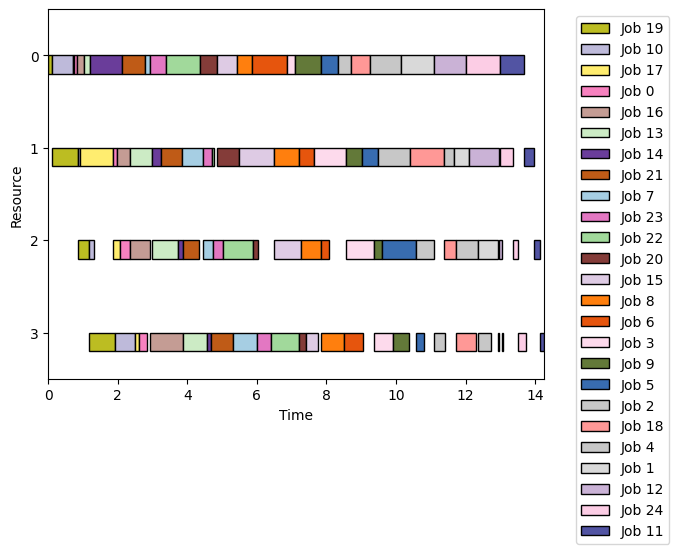

In [99]:
n_jobs = 25
n_machines = 4
param = {
    'problem_getter': PFSSP,
    'n_jobs': n_jobs,
    'n_machines': n_machines,
    'processing_times': np.random.rand(n_jobs, n_machines),
    'alg_name': 'nsga2', # Siehe algorithm_factory.py
    'crossover': OrderCrossover(),
    'mutation': InversionMutation(),
    'sampling': PermutationRandomSampling(),
    'adaptive_rate_mode': 'imdc', # none | icdm (incr. crossover, decr. mutation) | imdc (incr. mutation, decr. crossover)
    'obj_weights': [0.8,0.2], # Gewichte für die beiden zu optimierenden Zielgrößen
    'n_evals': 1800, # Max. Anz. der Evaluationen (Stopping-Kriterium anstelle von max. Anz. Generationen)
    'parallelization_method': 'multi_threading', # multi_threading | multi_processing | dask
    'n_parallelizations': 4, # Anzahl paralleler Prozesse oder Threads
    'eliminate_duplicates': False, # Eliminiere Duplikate (redundante Individuen)
    'seed': None, # Starte mit Zufallszahl
    'print_results': True, # Endergebnis ausgeben
    'print_iterations': True, # Zwischenergebnis ausgeben je Generation/Iteration
    'plot_solution': True, # Diagramm ausgeben
}
result, best_schedule, makespan_flowtime = run_alg_parallel(run_alg, param)